In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# "use_cls_token" is *intentionally* crippling the MS pretext
# the hope is that it makes it more useful for the engineering task
# ok, now I know the arch works... need to shrink it for the peptide task

In [4]:
hparams = dict(
    # datamodule
    hdf_path='./data/ProteomeTools.hdf',
    batch_size=1024,
    train_val_split=0.9,
    cdhit_threshold=0.5,
    cdhit_word_length=3,
    tmp_env='TMPDIR',
    num_workers=20,
    random_state=0,
    
    # model
    model_dim=512,
    model_depth=4,
    num_heads=4,
    lr=1e-4,
    dropout=0.1, 
    max_length=100,
    use_cls_token=True,

    # trainer
    num_gpus=1,
    max_epochs=50,
    precision=32,
    strategy='ddp',
    
    # cluster
    num_nodes=4,
    num_cpus=20,
    conda_env='MSPretraining',
    time='0-12:00:00',
    
    # tensorboard
    login_node='login-2'
)

In [5]:
args = ' '.join([f'--{k} {v}' for k,v in hparams.items()])

slurm = f'''#!/bin/bash -l

#SBATCH --nodes={hparams['num_nodes']}
#SBATCH --gres=gpu:volta:{hparams['num_gpus']}
#SBATCH --ntasks-per-node={max(1,hparams['num_gpus'])}
#SBATCH --cpus-per-task={hparams['num_cpus']}
#SBATCH --time={hparams['time']}
#SBATCH --signal=SIGUSR1@90

source activate {hparams['conda_env']}
''' + '''
export NCCL_DEBUG=INFO
export PYTHONFAULTHANDLER=1

# Set some environment variables needed by torch.distributed 
export MASTER_ADDR=$(hostname -s)
# Get unused port
export MASTER_PORT=$(python -c 'import socket; s=socket.socket(); s.bind(("", 0)); print(s.getsockname()[1]); s.close()')

echo "MASTER_ADDR : ${MASTER_ADDR}"
echo "MASTER_PORT : ${MASTER_PORT}"
''' + f'''
srun python train.py {args}
'''

%store slurm >submit.sh

Writing 'slurm' (str) to file 'submit.sh'.


In [6]:
!sbatch submit.sh

Submitted batch job 15655593


In [15]:
from src.torch_helpers import start_tensorboard

start_tensorboard(login_node=hparams['login_node'])

In [7]:
# it would be quite cool to UMAP the peptides!

In [63]:
from src.datamodule import MSDataModule
from src.model import MSTransformer

dm = MSDataModule(**hparams)
[last_ckpt] = !ls -t1 ./lightning_logs/*/checkpoints/*.ckpt | head -n1
print(last_ckpt)
model = MSTransformer.load_from_checkpoint(last_ckpt)

dm.setup()
model = model.cpu()
model.eval();

./lightning_logs/version_15655593/checkpoints/epoch=37-step=24927.ckpt


In [64]:
embeddings = []
sequences = []
for i, batch in tqdm(enumerate(dm.val_dataloader())):
    z = model.encoder(
        sequence=batch['x'],
        sequence_mask=batch['x_mask']
    )
    z = z.squeeze(1).detach().cpu().numpy()
    embeddings.append(z)
    sequences += batch['sequence']
    if len(sequences) >= 30000:
        break
embeddings = np.concatenate(embeddings,0)
embeddings.shape

29it [00:42,  1.45s/it]


(30720, 512)

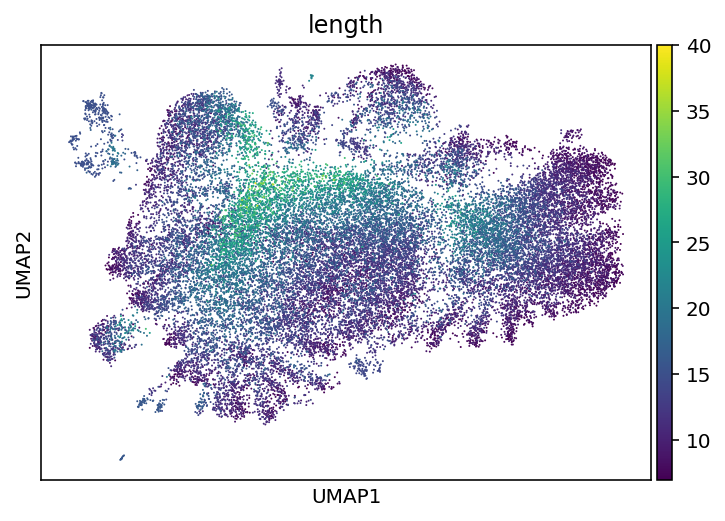

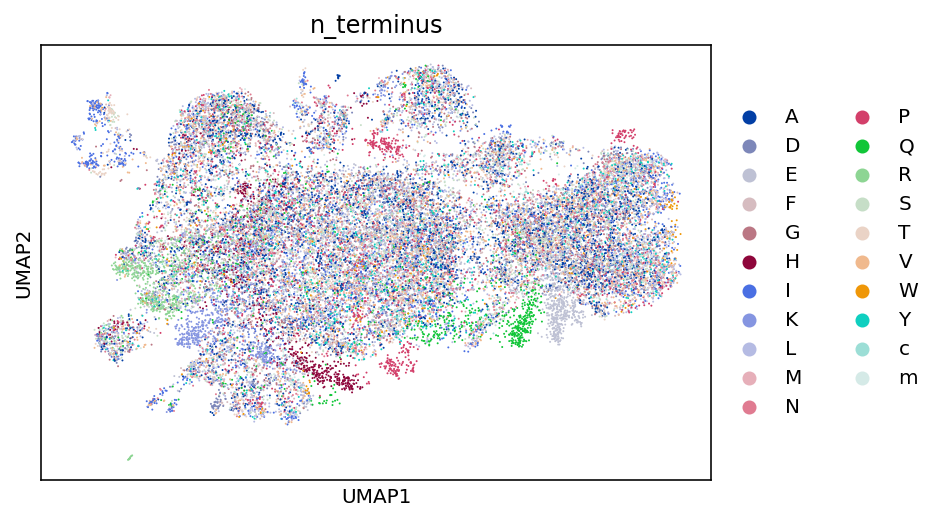

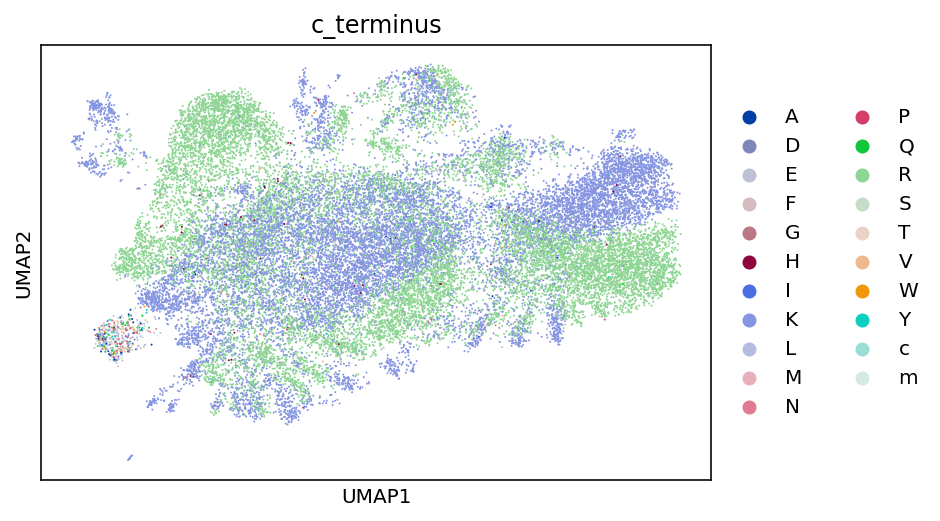

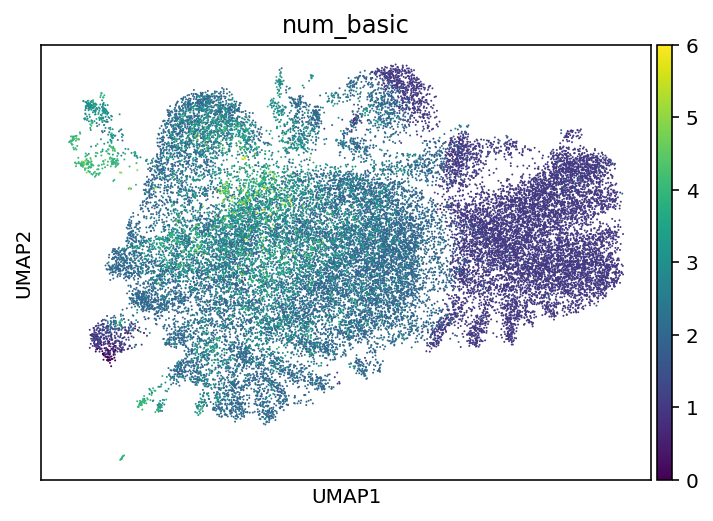

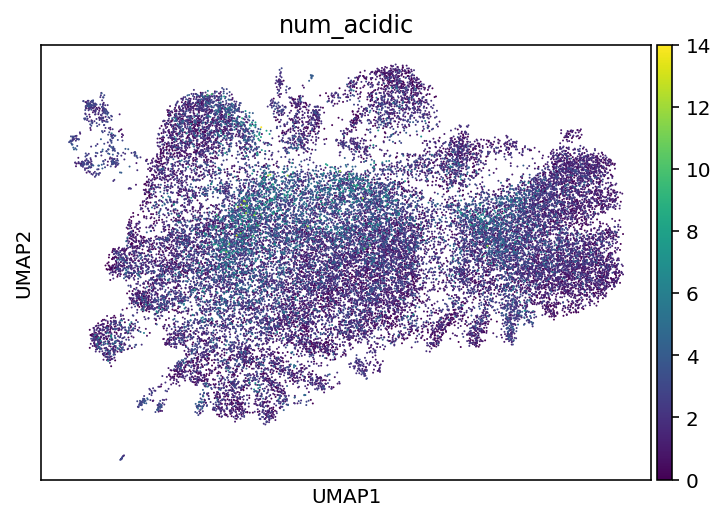

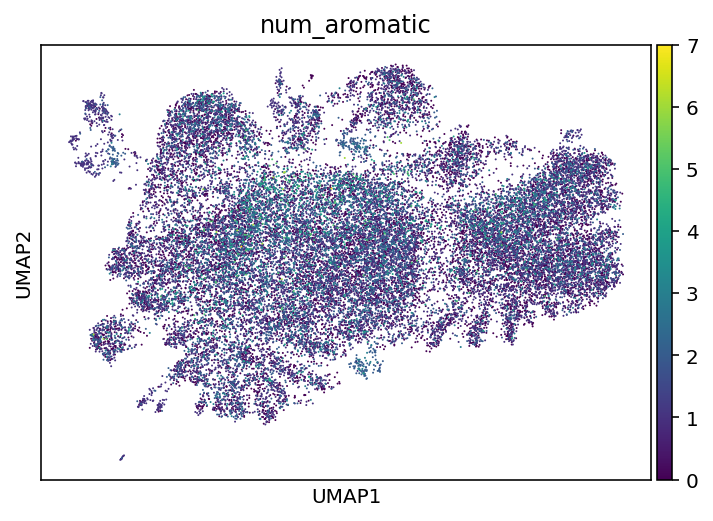

In [65]:
# this is cool. I suspect C-term structure is information-theoretic in origin

import scanpy as sc

adata = sc.AnnData(embeddings)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

adata.obs['sequence'] = sequences
adata.obs['length'] = adata.obs['sequence'].map(len)
adata.obs['n_terminus'] = adata.obs['sequence'].map(lambda s: s[0])
adata.obs['c_terminus'] = adata.obs['sequence'].map(lambda s: s[-1])
adata.obs['num_basic'] = adata.obs['sequence'].map(lambda s: sum([c in 'RKH' for c in s]))
adata.obs['num_acidic'] = adata.obs['sequence'].map(lambda s: sum([c in 'DE' for c in s]))
adata.obs['num_aromatic'] = adata.obs['sequence'].map(lambda s: sum([c in 'FYW' for c in s]))

sc.pl.umap(adata,color=['length'])
sc.pl.umap(adata,color=['n_terminus'])
sc.pl.umap(adata,color=['c_terminus'])
sc.pl.umap(adata,color=['num_basic'])
sc.pl.umap(adata,color=['num_acidic'])
sc.pl.umap(adata,color=['num_aromatic'])

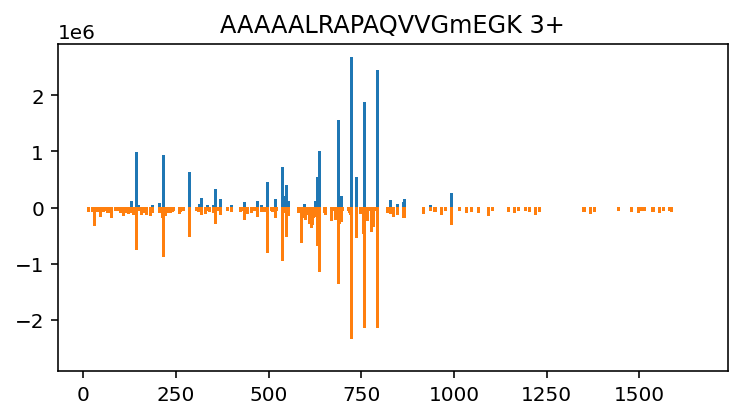

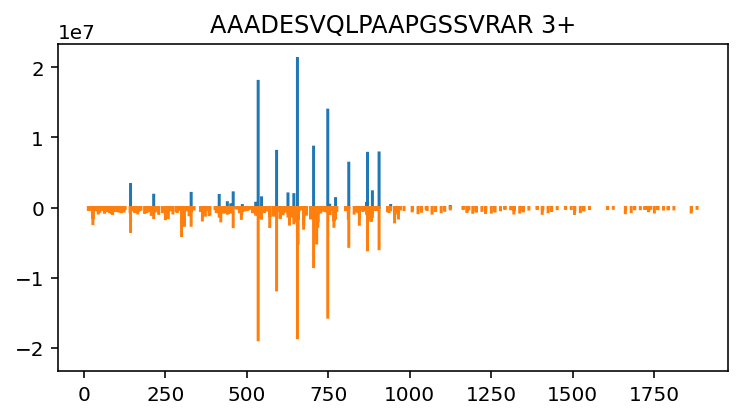

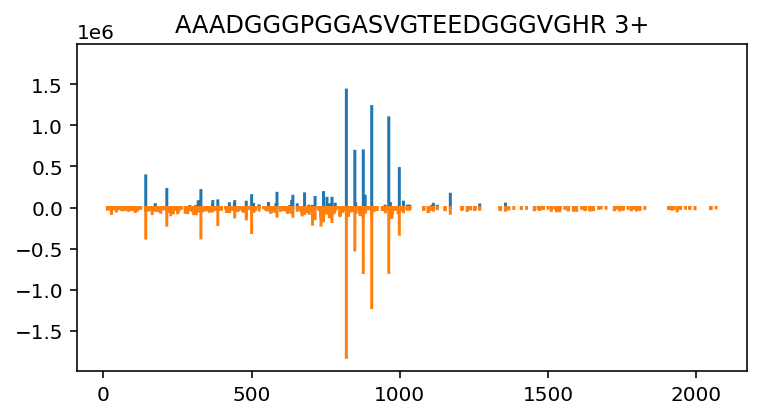

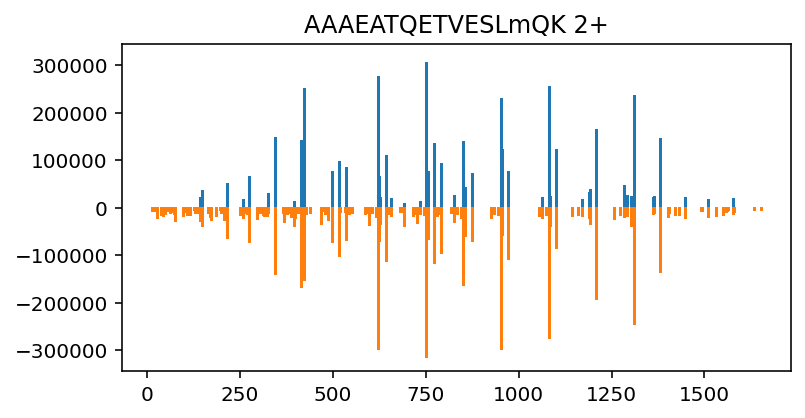

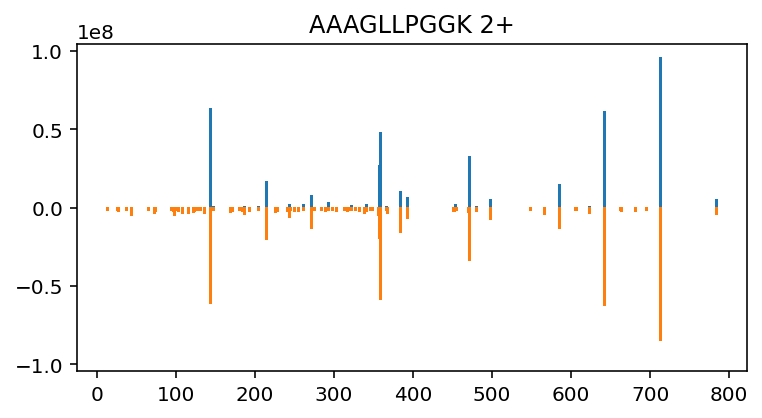

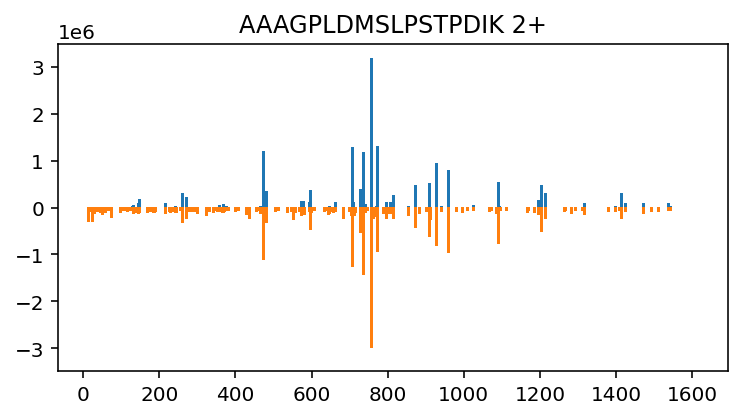

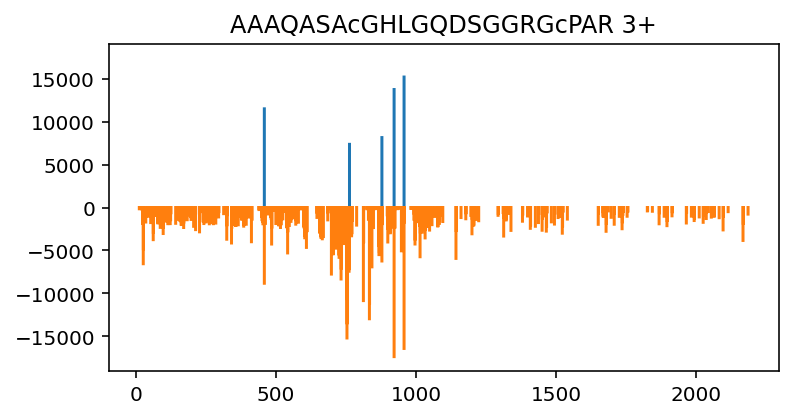

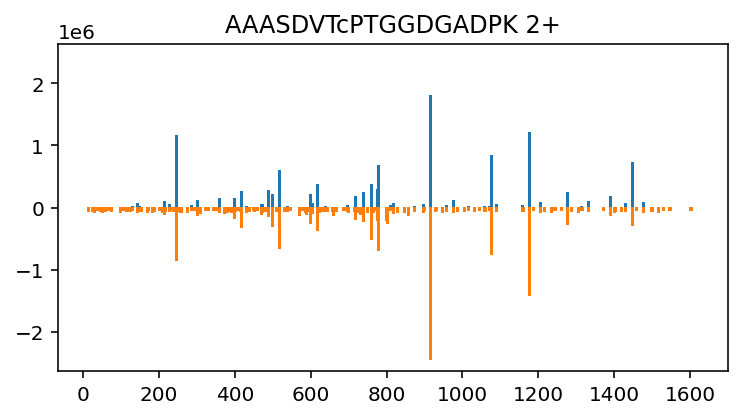

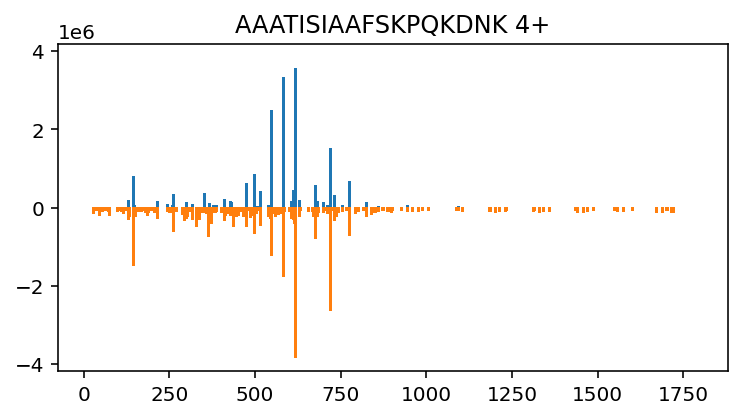

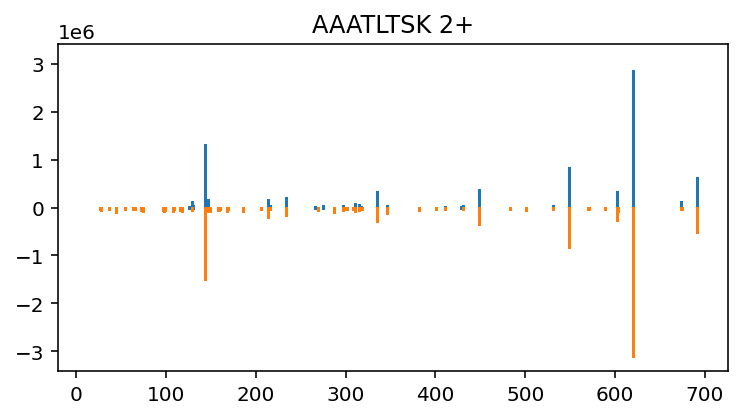

In [66]:
from src.plotting import faststem
from src.spectrum import fragment_mz_tensor
from tqdm import tqdm

for i, batch in enumerate(dm.predict_dataloader(shuffle=False)):
    if i == 10:
        break
        
    batch['y_pred'] = model.predict_step(batch)

    mz = fragment_mz_tensor(batch['sequence'][0]).ravel()
    y = batch['y'][0].detach().cpu().numpy().ravel()
    y_pred = batch['y_pred'][0].detach().cpu().numpy().ravel()
    
    plt.figure(figsize=(6,3))
    faststem(mz,y)
    faststem(mz,-y_pred)
    yl = max(np.abs(plt.ylim()))
    plt.ylim([-yl,yl])
    plt.title(f"{batch['sequence'][0]} {batch['charge'][0]}+")